In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from math import sqrt
%matplotlib inline

plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = 8,6
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# First, let's load the CSV files to inspect the data and understand their structure.

import pandas as pd

# Load the datasets
train_df = pd.read_csv('Dataset-2/train.csv')
test_df = pd.read_csv('Dataset-2/test.csv')
val_df = pd.read_csv('Dataset-2/val.csv')

# Displaying the first few rows of each dataset to understand the structure
train_df.head(), test_df.head(), val_df.head()


(         x1        x2  label
 0  1.002129  0.110730      0
 1 -0.893675 -0.238416      0
 2  0.111098 -1.024760      0
 3  0.729515  0.202157      1
 4 -0.643136  0.831671      0,
          x1        x2  label
 0  0.625994 -0.493261      1
 1 -0.903388  0.440527      0
 2 -0.476491 -0.658239      1
 3 -0.143176  0.803262      1
 4  0.515881 -0.546167      1,
          x1        x2  label
 0 -0.666352  0.414412      1
 1  0.413934 -0.908955      0
 2  0.547418 -0.761312      0
 3 -0.744947  0.372928      1
 4  0.648137  0.512726      1)

In [3]:
# Load the data (assuming train_df, test_df, val_df have been loaded)
x_train = train_df[['x1', 'x2']].values
y_train = train_df['label'].values
x_test = test_df[['x1', 'x2']].values
y_test = test_df['label'].values
x_val = val_df[['x1', 'x2']].values
y_val = val_df['label'].values

In [4]:

from math import sqrt
# Function to compute Euclidean distance
def euclidean(a, b):
    return sqrt(np.sum((np.array(a) - np.array(b)) ** 2))
    
# Function to evaluate the accuracy of predictions
def evaluate_accuracy(y_true, y_pred):
    correct = np.sum(np.array(y_true) == np.array(y_pred))
    return correct / len(y_true)


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.unique(y_true), 
                yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [5]:
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import confusion_matrix

# Function to get M representatives per class using KMeans
def get_representatives(x, y, M):
    representatives = []
    labels = []

    unique_classes = np.unique(y)
    
    for cls in unique_classes:
        class_points = x[y == cls]
        
        # Use KMeans to find M representatives for each class
        kmeans = KMeans(n_clusters=M, random_state=42)
        kmeans.fit(class_points)
        
        # Get the M cluster centers as representatives
        representatives.extend(kmeans.cluster_centers_)
        labels.extend([cls] * M)  # Assign the class label to each representative
    
    return np.array(representatives), np.array(labels)


In [6]:
# KNN-like classification function for representatives
def knr_classify(representatives, rep_labels, test_point, k):
    distances = []
    
    # Compute distance between the test point and each representative
    for i in range(len(representatives)):
        d = euclidean(representatives[i], test_point)
        distances.append((d, rep_labels[i]))
    
    # Sort by distance
    distances.sort(key=lambda x: x[0])
    
    # Take the k nearest representatives
    count = Counter()
    for i in distances[:k]:
        count[i[1]] += 1
    
    # Return the class with the highest vote (or break ties as before)
    max_count = count.most_common(1)[0][1]
    tied_classes = [key for key, value in count.items() if value == max_count]
    
    pred = tied_classes[0]
    
    if len(tied_classes) > 1:
        class_avg_dist = {}
        for cls in tied_classes:
            cls_distances = [d[0] for d in distances[:k] if d[1] == cls]
            class_avg_dist[cls] = np.mean(cls_distances)
        pred = min(class_avg_dist, key=class_avg_dist.get)
    
    return pred

# Function to predict using KNR for a dataset
def knr_predict(representatives, rep_labels, x_test, k):
    predictions = []
    for test_point in x_test:
        pred = knr_classify(representatives, rep_labels, test_point, k)
        predictions.append(pred)
    return predictions


In [7]:
# Function to evaluate performance and print accuracy and confusion matrix
def evaluate_classifier(y_true, y_pred, dataset_name):
    accuracy = evaluate_accuracy(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Accuracy on {dataset_name}: {accuracy}")
    plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix on {dataset_name}")
    
    return accuracy, cm


In [8]:
def plot_decision_regions_knr(x_train, y_train, representatives, rep_labels, k, h=0.1):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    # Define the min and max for the grid based on training data
    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1

    # Generate a grid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Flatten the grid to pass into the prediction function
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Use KNR function to predict the class for each grid point
    Z = knr_predict(representatives, rep_labels, grid_points, k)

    # Reshape the result back into the grid shape
    Z = np.array(Z).reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot the training points
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=50)
    
    # Plot the representatives
    plt.scatter(representatives[:, 0], representatives[:, 1], c=rep_labels, cmap=cmap_bold, 
                edgecolor='yellow', marker='*', s=200, label='Representatives')
    
    plt.title(f"Decision Boundary for K={k} with M={len(representatives)//len(np.unique(rep_labels))} Representatives")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend(loc='upper right')
    plt.show()



Results for K=1:
Accuracy on Test Data: 0.825


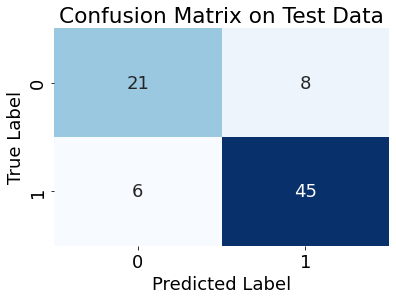

Accuracy on Validation Data: 0.8679245283018868


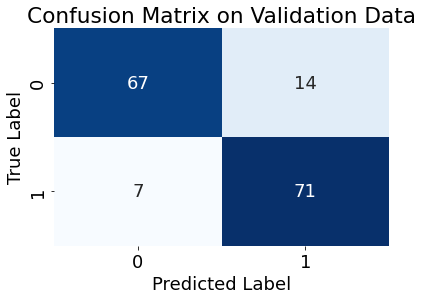

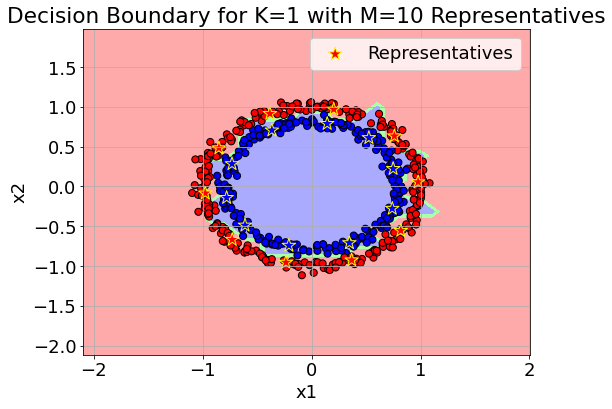


Results for K=3:
Accuracy on Test Data: 0.7375


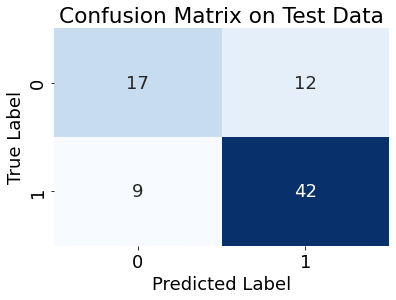

Accuracy on Validation Data: 0.6792452830188679


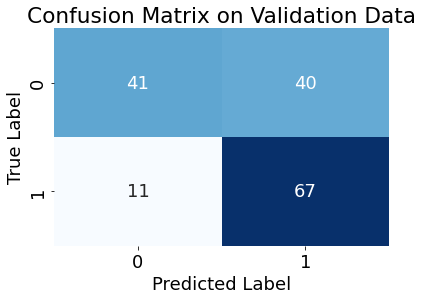

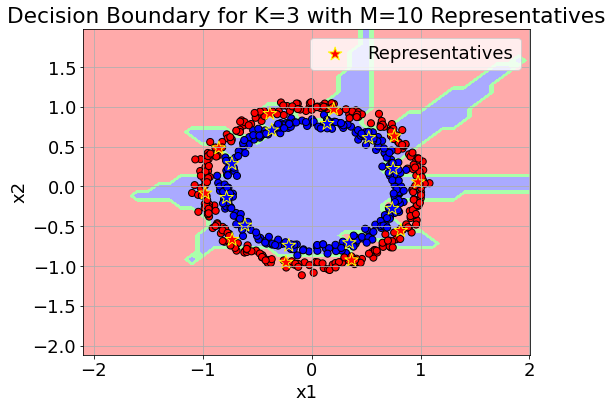


Results for K=5:
Accuracy on Test Data: 0.6625


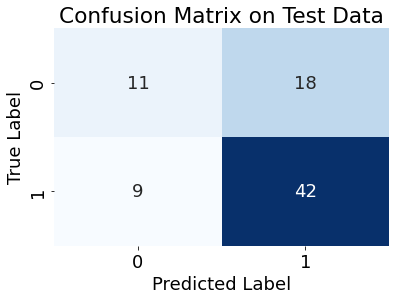

Accuracy on Validation Data: 0.6729559748427673


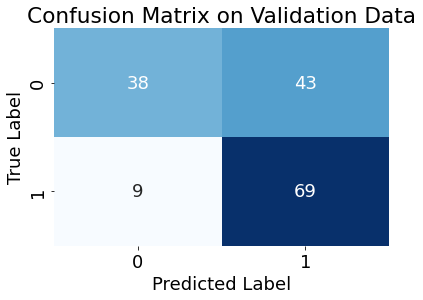

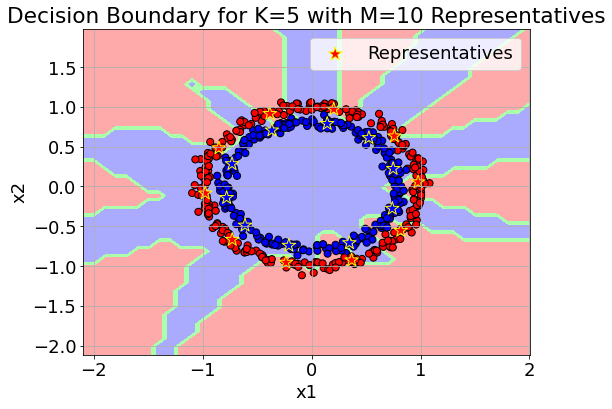

In [10]:
M = 10  # Number of representatives per class
k_values = [1, 3, 5]

# Get M representatives for each class from the training data
representatives, rep_labels = get_representatives(x_train, y_train, M)

# Loop through different K values and evaluate performance
for k in k_values:
    print(f"\nResults for K={k}:")

    # Predict on test data
    test_predictions = knr_predict(representatives, rep_labels, x_test, k)
    evaluate_classifier(y_test, test_predictions, "Test Data")

    # Predict on validation data
    val_predictions = knr_predict(representatives, rep_labels, x_val, k)
    evaluate_classifier(y_val, val_predictions, "Validation Data")

    # Plot decision boundary
    plot_decision_regions_knr(x_train, y_train, representatives, rep_labels, k)


In [11]:
import pandas as pd

# Lists to store accuracies for different k values
Accuracyknr_train = []
Accuracyknr_val = []
Accuracyknr_test = []

# Number of representatives per class
M = 10

# Get M representatives for each class from the training data
representatives, rep_labels = get_representatives(x_train, y_train, M)

print(f"\nEvaluating KNR for M={M}:")
# Loop through different K values and evaluate performance
for k in k_values:

    # Predict on training data
    train_predictions = knr_predict(representatives, rep_labels, x_train, k)
    train_accuracy = evaluate_accuracy(y_train, train_predictions)
    Accuracyknr_train.append(train_accuracy)

    # Predict on validation (CV) data
    val_predictions = knr_predict(representatives, rep_labels, x_val, k)
    val_accuracy = evaluate_accuracy(y_val, val_predictions)
    Accuracyknr_val.append(val_accuracy)

    # Predict on test data
    test_predictions = knr_predict(representatives, rep_labels, x_test, k)
    test_accuracy = evaluate_accuracy(y_test, test_predictions)
    Accuracyknr_test.append(test_accuracy)

# Create a DataFrame to store the accuracies for different k values
accuracy_table_KNR = pd.DataFrame(
    {
        "k-value": k_values,
        "Accuracy Train": Accuracyknr_train,
        "Accuracy Val": Accuracyknr_val,
        "Accuracy Test": Accuracyknr_test,
    }
)

# Display the accuracy table
print(accuracy_table_KNR)



Evaluating KNR for M=10:
   k-value  Accuracy Train  Accuracy Val  Accuracy Test
0        1        0.900178      0.867925         0.8250
1        3        0.661319      0.679245         0.7375
2        5        0.565062      0.672956         0.6625
